<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/pR50_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_model_optimization

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import os
import tracemalloc
import tensorflow_model_optimization as tfmot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.0 MB/s eta 0:00:00


In [3]:
# Define paths
train_dir = '/content/drive/MyDrive/motor_data/train'
validation_dir = '/content/drive/MyDrive/motor_data/validation'
test_dir = '/content/drive/MyDrive/motor_data/test'

# Set image size and batch size
image_size = (224, 224)
batch_size = 32

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
validation_dataset = image_dataset_from_directory(validation_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
test_dataset = image_dataset_from_directory(test_dir, image_size=image_size, batch_size=batch_size, label_mode='int')

Found 12004 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4004 files belonging to 4 classes.


In [4]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: normal, fault_BB, fault_SM, fault_RI
])

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [5]:

# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 952s 2s/step - loss: 0.1036 - accuracy: 0.9889 - val_loss: 101739.2109 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 800s 2s/step - loss: 0.0237 - accuracy: 0.9962 - val_loss: 4.5302 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 794s 2s/step - loss: 4.9568e-04 - accuracy: 0.9999 - val_loss: 7.6388e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 793s 2s/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0675 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 790s 2s/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 1.1585e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 792s 2s/step - loss: 7.6475e-05 - accuracy: 1.0000 - val_loss: 1.9228e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376 [===================

In [6]:
# Initial evaluation
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Initial Validation Loss: {val_loss}")
print(f"Initial Validation Accuracy: {val_acc}")

125/125 [==============================] - 68s 537ms/step - loss: 2.1245e-04 - accuracy: 1.0000
Initial Validation Loss: 0.00021244936215225607
Initial Validation Accuracy: 1.0


In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Initial Test Loss: {test_loss}")
print(f"Initial Test Accuracy: {test_acc}")

126/126 [==============================] - 144s 1s/step - loss: 6.0968e-04 - accuracy: 0.9998
Initial Test Loss: 0.0006096798460930586
Initial Test Accuracy: 0.9997502565383911


In [8]:
# Save initial model and measure size
model.save('original_motor_fault_classification_model.h5')
original_model_size = os.path.getsize('original_motor_fault_classification_model.h5')
print(f"Original Model Size: {original_model_size / (1024 * 1024):.2f} MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Original Model Size: 282.31 MB


In [9]:
# Measure initial inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true, y_pred = [], []
for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
original_inference_time = end_time - start_time
original_peak_memory = peak / (1024 * 1024)
print(f"Original Inference Time: {original_inference_time:.2f} seconds")
print(f"Original Peak Memory Usage: {original_peak_memory:.2f} MB")

1/1 [==============================] - 2s 2s/step
Original Inference Time: 85.22 seconds
Original Peak Memory Usage: 5.83 MB


In [10]:
# Initial model evaluation metrics
conf_matrix_original = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Original):")
print(conf_matrix_original)

print("Classification Report (Original):")
print(classification_report(y_true, y_pred, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Original):
[[1004    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   1    0    0  999]]
Classification Report (Original):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



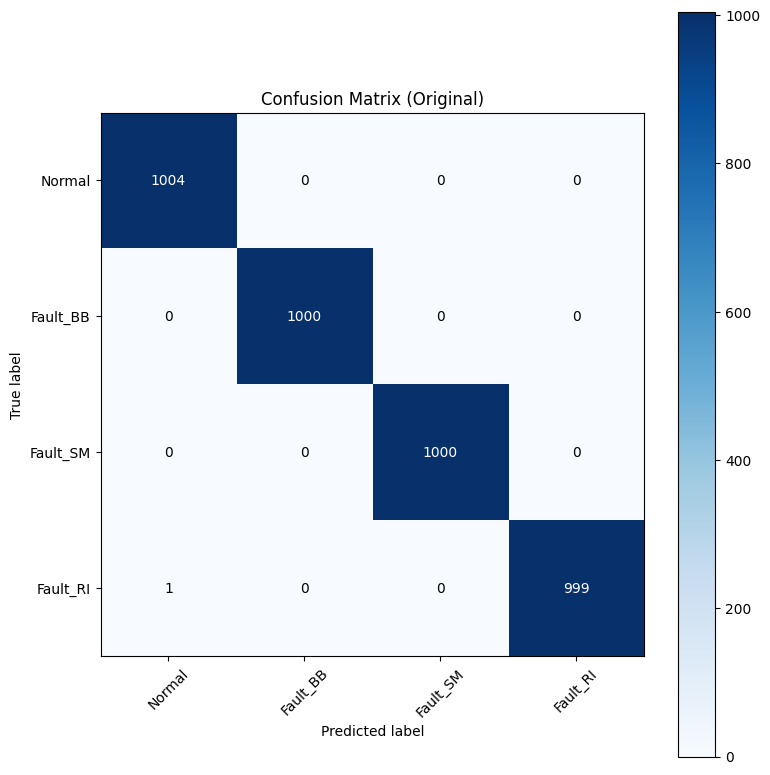

In [11]:
# Visualize initial confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_original, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Original)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_original.max() / 2.
for i, j in np.ndindex(conf_matrix_original.shape):
    plt.text(j, i, format(conf_matrix_original[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_original[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [12]:
# Calculate additional initial metrics
f1_original = f1_score(y_true, y_pred, average='weighted')
precision_original = precision_score(y_true, y_pred, average='weighted')
recall_original = recall_score(y_true, y_pred, average='weighted')

print(f"Original F1 Score: {f1_original:.2f}")
print(f"Original Precision: {precision_original:.2f}")
print(f"Original Recall: {recall_original:.2f}")

Original F1 Score: 1.00
Original Precision: 1.00
Original Recall: 1.00


In [13]:
# Structured Pruning 적용
def apply_structured_pruning(model, pruning_percentage=50):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            num_filters = weights.shape[-1]
            num_prune = int(num_filters * pruning_percentage / 100)

            # Compute the L1 norm of the filters
            filter_norms = np.sum(np.abs(weights), axis=(0, 1, 2))
            prune_indices = np.argsort(filter_norms)[:num_prune]

            # Set the weights of the pruned filters to zero
            for idx in prune_indices:
                weights[:, :, :, idx] = 0

            layer.set_weights([weights, biases])

apply_structured_pruning(model, pruning_percentage=70)

# Recompile pruned model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Train pruned model
history_pruned = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])

Epoch 1/10
376/376 [==============================] - 821s 2s/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.0209 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 802s 2s/step - loss: 0.0133 - accuracy: 0.9978 - val_loss: 1.1972e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 811s 2s/step - loss: 0.0185 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 809s 2s/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 5.9384e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 803s 2s/step - loss: 2.1373e-05 - accuracy: 1.0000 - val_loss: 9.0567e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 804s 2s/step - loss: 0.0140 - accuracy: 0.9999 - val_loss: 7.2173e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376 [========================

In [15]:
# Evaluate pruned model
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Pruned Validation Loss: {val_loss}")
print(f"Pruned Validation Accuracy: {val_acc}")

125/125 [==============================] - 70s 556ms/step - loss: 1.2212e-05 - accuracy: 1.0000
Pruned Validation Loss: 1.221154070663033e-05
Pruned Validation Accuracy: 1.0


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Pruned Test Loss: {test_loss}")
print(f"Pruned Test Accuracy: {test_acc}")

126/126 [==============================] - 71s 554ms/step - loss: 7.5806e-05 - accuracy: 1.0000
Pruned Test Loss: 7.58060414227657e-05
Pruned Test Accuracy: 1.0


In [17]:
# Strip pruning wrappers and save pruned model
model_for_export = tfmot.sparsity.keras.strip_pruning(model)
model_for_export.save('pruned_motor_fault_classification_model.h5')
pruned_model_size = os.path.getsize('pruned_motor_fault_classification_model.h5')
print(f"Pruned Model Size: {pruned_model_size / (1024 * 1024):.2f} MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pruned Model Size: 94.34 MB


In [18]:
# Measure pruned model inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true_pruned, y_pred_pruned = [], []
for batch in test_dataset:
    images, labels = batch
    y_true_pruned.extend(labels.numpy())
    predictions = model_for_export.predict(images)
    y_pred_pruned.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
pruned_inference_time = end_time - start_time
pruned_peak_memory = peak / (1024 * 1024)
print(f"Pruned Inference Time: {pruned_inference_time:.2f} seconds")
print(f"Pruned Peak Memory Usage: {pruned_peak_memory:.2f} MB")

1/1 [==============================] - 2s 2s/step
Pruned Inference Time: 84.38 seconds
Pruned Peak Memory Usage: 5.10 MB


In [19]:
# Pruned model evaluation metrics
conf_matrix_pruned = confusion_matrix(y_true_pruned, y_pred_pruned)
print("Confusion Matrix (Pruned):")
print(conf_matrix_pruned)

print("Classification Report (Pruned):")
print(classification_report(y_true_pruned, y_pred_pruned, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

Confusion Matrix (Pruned):
[[1004    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
Classification Report (Pruned):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



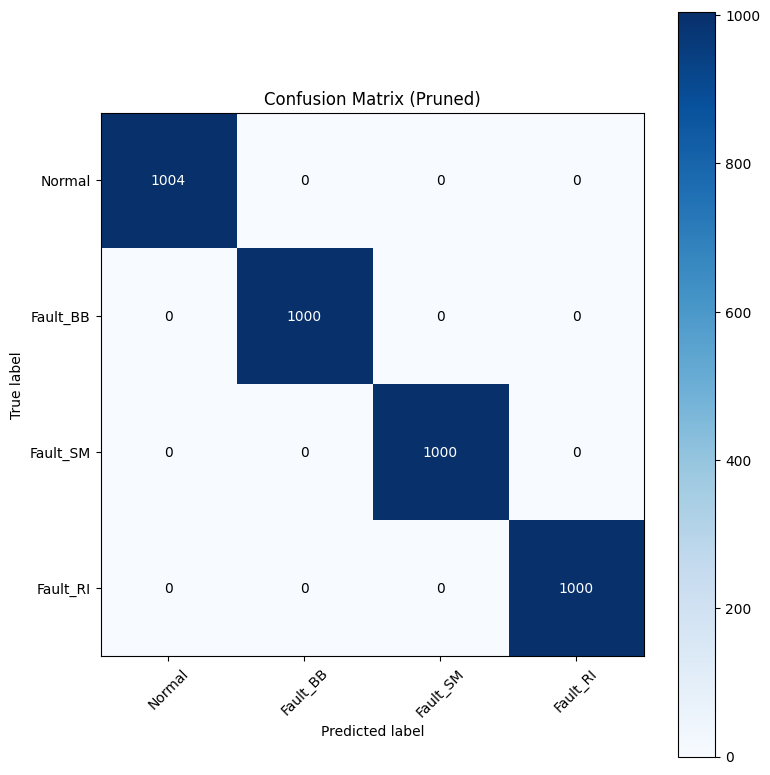

In [20]:
# Visualize pruned confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_pruned, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Pruned)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_pruned.max() / 2.
for i, j in np.ndindex(conf_matrix_pruned.shape):
    plt.text(j, i, format(conf_matrix_pruned[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_pruned[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [21]:
# Calculate additional pruned metrics
f1_pruned = f1_score(y_true_pruned, y_pred_pruned, average='weighted')
precision_pruned = precision_score(y_true_pruned, y_pred_pruned, average='weighted')
recall_pruned = recall_score(y_true_pruned, y_pred_pruned, average='weighted')

print(f"Pruned F1 Score: {f1_pruned:.2f}")
print(f"Pruned Precision: {precision_pruned:.2f}")
print(f"Pruned Recall: {recall_pruned:.2f}")

Pruned F1 Score: 1.00
Pruned Precision: 1.00
Pruned Recall: 1.00


In [22]:
# Apply weight clustering
cluster_weights = tfmot.clustering.keras.cluster_weights
strip_clustering = tfmot.clustering.keras.strip_clustering

clustering_params = {
    'number_of_clusters': 32,
    'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
}

clustered_model = cluster_weights(model_for_export, **clustering_params)

In [23]:
# Recompile clustered model
clustered_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


In [24]:
# Train clustered model
history_clustered = clustered_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr])


Epoch 1/10
376/376 [==============================] - 992s 3s/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 7.9143e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 973s 3s/step - loss: 2.4623e-07 - accuracy: 1.0000 - val_loss: 4.8941e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 979s 3s/step - loss: 1.0635e-07 - accuracy: 1.0000 - val_loss: 3.1278e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 981s 3s/step - loss: 5.4281e-08 - accuracy: 1.0000 - val_loss: 2.1027e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
376/376 [==============================] - 981s 3s/step - loss: 2.9842e-08 - accuracy: 1.0000 - val_loss: 1.5432e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
376/376 [==============================] - 985s 3s/step - loss: 1.8868e-08 - accuracy: 1.0000 - val_loss: 1.1490e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
376/376 [

In [25]:
# Evaluate clustered model
val_loss, val_acc = clustered_model.evaluate(validation_dataset)
print(f"Clustered Validation Loss: {val_loss}")
print(f"Clustered Validation Accuracy: {val_acc}")

125/125 [==============================] - 129s 1s/step - loss: 9.1869e-08 - accuracy: 1.0000
Clustered Validation Loss: 9.186880589595603e-08
Clustered Validation Accuracy: 1.0


In [26]:
test_loss, test_acc = clustered_model.evaluate(test_dataset)
print(f"Clustered Test Loss: {test_loss}")
print(f"Clustered Test Accuracy: {test_acc}")


126/126 [==============================] - 130s 1s/step - loss: 4.9700e-06 - accuracy: 1.0000
Clustered Test Loss: 4.970031568518607e-06
Clustered Test Accuracy: 1.0


In [28]:
# Strip clustering wrappers and save clustered model
clustered_model_path = 'clustered_motor_fault_classification_model.keras'
final_model = strip_clustering(clustered_model)
if os.path.exists(clustered_model_path):
    os.remove(clustered_model_path)
final_model.save(clustered_model_path)
clustered_model_size = os.path.getsize(clustered_model_path)
print(f"Clustered Model Size: {clustered_model_size / (1024 * 1024):.2f} MB")

Clustered Model Size: 94.54 MB


In [29]:
# Measure clustered model inference time and memory usage
start_time = time.time()
tracemalloc.start()
y_true_clustered, y_pred_clustered = [], []
for batch in test_dataset:
    images, labels = batch
    y_true_clustered.extend(labels.numpy())
    predictions = final_model.predict(images)
    y_pred_clustered.extend(np.argmax(predictions, axis=1))
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
clustered_inference_time = end_time - start_time
clustered_peak_memory = peak / (1024 * 1024)
print(f"Clustered Inference Time: {clustered_inference_time:.2f} seconds")
print(f"Clustered Peak Memory Usage: {clustered_peak_memory:.2f} MB")

1/1 [==============================] - 2s 2s/step
Clustered Inference Time: 84.56 seconds
Clustered Peak Memory Usage: 5.14 MB


Confusion Matrix (Clustered):
[[1004    0    0    0]
 [   0 1000    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
Classification Report (Clustered):
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1004
    fault_BB       1.00      1.00      1.00      1000
    fault_SM       1.00      1.00      1.00      1000
    fault_RI       1.00      1.00      1.00      1000

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004



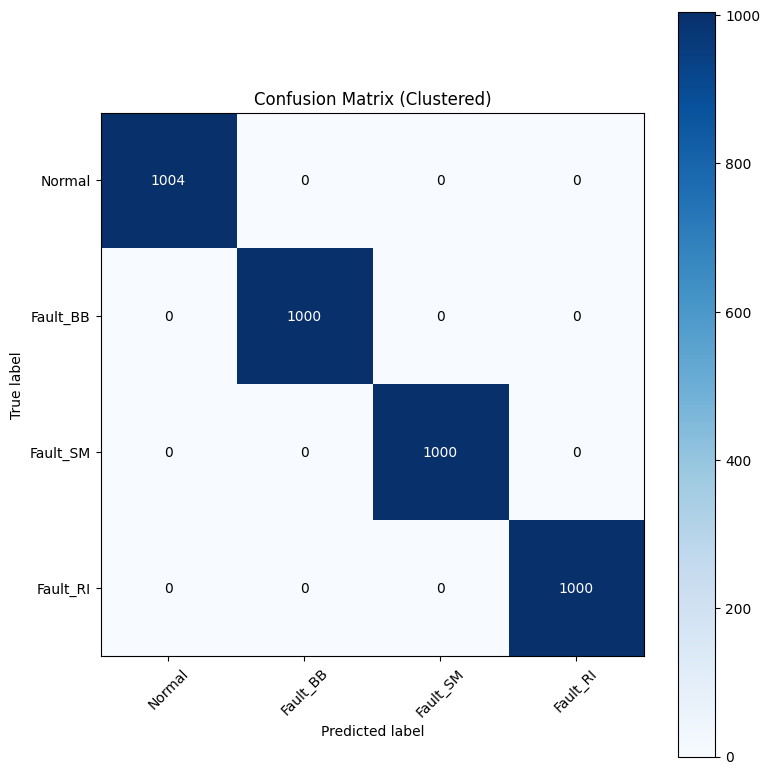

In [30]:
# Clustered model evaluation metrics
conf_matrix_clustered = confusion_matrix(y_true_clustered, y_pred_clustered)
print("Confusion Matrix (Clustered):")
print(conf_matrix_clustered)

print("Classification Report (Clustered):")
print(classification_report(y_true_clustered, y_pred_clustered, target_names=['normal', 'fault_BB', 'fault_SM', 'fault_RI']))

# Visualize clustered confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix_clustered, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Clustered)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Fault_BB', 'Fault_SM', 'Fault_RI'])

fmt = 'd'
thresh = conf_matrix_clustered.max() / 2.
for i, j in np.ndindex(conf_matrix_clustered.shape):
    plt.text(j, i, format(conf_matrix_clustered[i, j], fmt),
             ha="center", va="center",
             color="white" if conf_matrix_clustered[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [31]:
# Calculate additional clustered metrics
f1_clustered = f1_score(y_true_clustered, y_pred_clustered, average='weighted')
precision_clustered = precision_score(y_true_clustered, y_pred_clustered, average='weighted')
recall_clustered = recall_score(y_true_clustered, y_pred_clustered, average='weighted')

print(f"Clustered F1 Score: {f1_clustered:.2f}")
print(f"Clustered Precision: {precision_clustered:.2f}")
print(f"Clustered Recall: {recall_clustered:.2f}")

Clustered F1 Score: 1.00
Clustered Precision: 1.00
Clustered Recall: 1.00
